## 자료 가져오기

Reference : 

1. [히스토그램 - python opencv](https://opencv-python.readthedocs.io/en/latest/doc/19.imageHistograms/imageHistograms.html)
2. [히스토그램 평활화 - python opencv](https://opencv-python.readthedocs.io/en/latest/doc/20.imageHistogramEqualization/imageHistogramEqualization.html)

In [1]:
# 영상처리에 있어서 핵심적인 matplotlib과 opencv , numpy 가져오기
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
if not os.path.exists("hist_image.jpg"):
    !wget https://imagej.net/_images/thumb/c/cd/Photo1.jpg/722px-Photo1.jpg
    !wget https://upload.wikimedia.org/wikipedia/commons/thumb/0/08/Unequalized_Hawkes_Bay_NZ.jpg/600px-Unequalized_Hawkes_Bay_NZ.jpg
    os.rename("722px-Photo1.jpg","hist_image.jpg")
    os.rename('600px-Unequalized_Hawkes_Bay_NZ.jpg', 'hist_image2.jpg')


## Objective

1. Histogram에 대한 이해
2. Histogram Equalization에 대한 이해
3. CLAHE에 대한 이해

<h1 style = "background-color: rgba(185, 109, 106, 0.3);" > 영상에서의 histgram이란?</h1>

> Histogram은 이미지의 밝기의 분포를 그래프로 표현한 방식이다. 히스토그램을 이용하면 이미지의 전체의 밝기 분포와 채도(색의 밝고 어두움)을 알 수 있다. 영상의 색상 특징을 정량적으로 파악할 수 있는 수단 중 하나이다. 

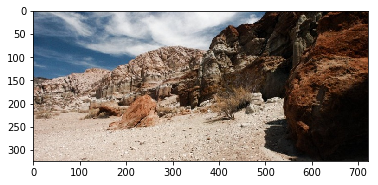

In [2]:
image = cv2.imread("./hist_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

### (1) 색깔 별 histogram 분포 그리기

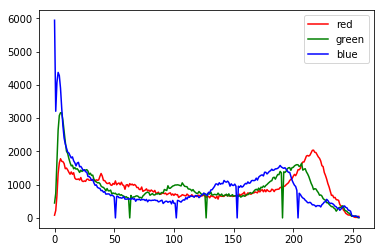

In [3]:
r_hist, r_bins = np.histogram(image[:,:,0], bins=256)
g_hist, g_bins = np.histogram(image[:,:,1], bins=256)
b_hist, b_bins = np.histogram(image[:,:,2], bins=256)

plt.plot(r_hist,'r',label='red')
plt.plot(g_hist,'g',label='green')
plt.plot(b_hist,'b',label='blue')
plt.legend()
plt.show()

### (2) 밝기의 histogram 분포 그리기

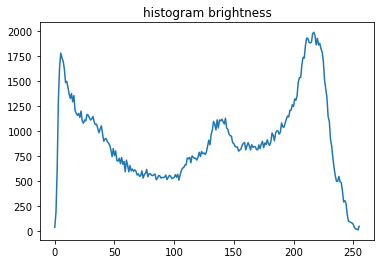

In [4]:
image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
brightness = image[:,:,2]
image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)

hist, bins = np.histogram(brightness, bins=256)

plt.title("histogram brightness")
plt.plot(hist)
plt.show()

### (3) histogram 평활화

> 위와 같은 이미지는 밝기가 낮은 곳과 높은 곳에 집중되어 있다. 이미지의 히스토그램이 특정 영역에 너무 집중되어 있으면 constrast가 낮게 된다. 즉, 색의 변화가 적어, 윤곽을 알아볼 수 없다. 이러한 영상에 histogram을 평활하는 작업을 해보자. 우선 다른 이미지에 적용해보자.

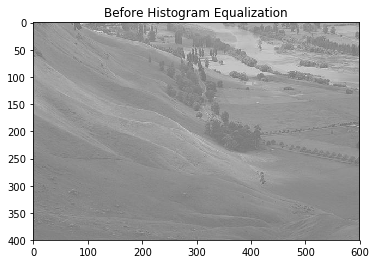

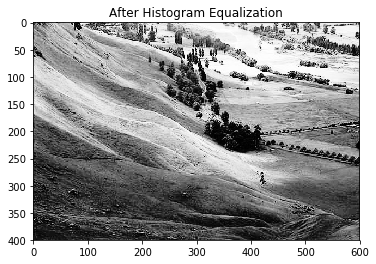

In [5]:
image = cv2.imread("./hist_image2.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
brightness = hsv[:,:,2]

hist, bins = np.histogram(brightness.flatten(), 256,[0,256])

cdf = hist.cumsum()

# cdf의 값이 0인 경우는 mask처리를 하여 계산에서 제외
# mask처리가 되면 Numpy 계산에서 제외가 됨
# 아래는 cdf array에서 값이 0인 부분을 mask처리함
cdf_m = np.ma.masked_equal(cdf,0)

#History Equalization 공식
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())

# Mask처리를 했던 부분을 다시 0으로 변환
cdf = np.ma.filled(cdf_m,0).astype('uint8')

hsv[:,:,2] = cdf[brightness]

after_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

plt.title("Before Histogram Equalization")
plt.imshow(image)
plt.show()
plt.title("After Histogram Equalization")
plt.imshow(after_image)
plt.show()

위와 같이 contrast를 살려줌으로써 뚜렷하게 영상에서 특징들이 보인다. 하지만 처음에 보았던 영상에 적용하면 어떠할까.

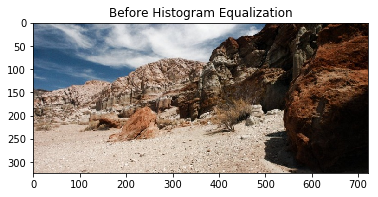

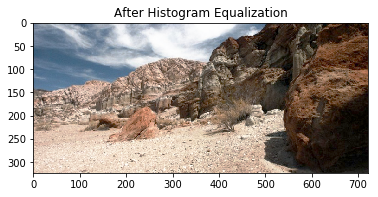

In [6]:
image = cv2.imread("./hist_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hist, bins = np.histogram(image.flatten(), 256,[0,256])

cdf = hist.cumsum()

# cdf의 값이 0인 경우는 mask처리를 하여 계산에서 제외
# mask처리가 되면 Numpy 계산에서 제외가 됨
# 아래는 cdf array에서 값이 0인 부분을 mask처리함
cdf_m = np.ma.masked_equal(cdf,0)

#History Equalization 공식
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())

# Mask처리를 했던 부분을 다시 0으로 변환
cdf = np.ma.filled(cdf_m,0).astype('uint8')

after_image = cdf[image]

plt.title("Before Histogram Equalization")
plt.imshow(image)
plt.show()
plt.title("After Histogram Equalization")
plt.imshow(after_image)
plt.show()

조금 더 윤곽선이 드러났지만 뭔가 아쉽다. 이렇게 일반적인 이미지에는 밝은 부분과 어두운 부분이 섞여 있어, 전체에 적용하는 것은 크게 효과가 약하다. 이걸 좀 더 살리기 위해서는, 구역 별로 나누어서 histogram Equalization을 적용할 필요가 있다. 

### (4) CLAHE

> CLAHE는 이미지를 작은 title형태로 나누어 그 title안에서 Equalization을 적용하는 방식입니다. 그런데 여기서도 한가지 문제가 있습니다. 작은 영역이다 보니 작은 노이즈(극단적으로 어둡거나, 밝은 영역)가 있으면 이것이 반영이 되어 원하는 결과를 얻을 수 없게 됩니다. 이 문제를 피하기 위해서 contrast limit라는 값을 적용하여 이 값을 넘어가는 경우는 그 영역은 다른 영역에 균일하게 배분하여 적용을 합니다.

*(아직 정확하게 Logic이 파악되지 않았음)*

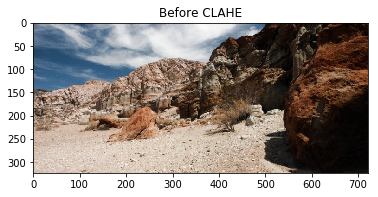

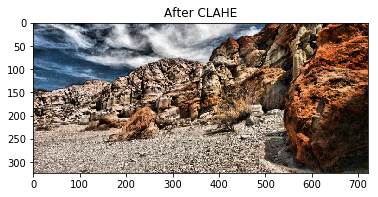

In [7]:
image = cv2.imread("./hist_image.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
brightness = hsv[:,:,2]

# contrast limit가 4이고 title의 size는 16,16
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
hsv[:,:,2] = clahe.apply(brightness)

after_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

plt.title("Before CLAHE")
plt.imshow(image)
plt.show()
plt.title("After CLAHE")
plt.imshow(after_image)
plt.show()

<hr>

Copyright(c) 2019 by Public AI. All rights reserved. last updated on 2019/02/03<br>
Writen by PAI, SangJae Kang(rocketgrowthsj@publicai.co.kr) 
<hr>